In [1]:
%load_ext watermark
import pandas as pd
import numpy as np
import datetime as dt
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
import json

# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF; text-align:right'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 10px;'}
table_data = {'selector': 'td', 'props': 'padding: 6px;'}
table_caption = {'selector': 'caption', 'props': 'font-size: 14px; font-style: italic; caption-side: bottom; text-align: left; margin-top: 10px'}
table_css_styles = [even_rows, odd_rows, table_font, header_row, table_caption]

table_large_data = {'selector': 'tr', 'props': 'font-size: 14px;'}
table_large_font = [even_rows, odd_rows, table_large_data, header_row, table_caption]

def rotateText(x):
    return 'writing-mode: vertical-lr; transform: rotate(-180deg);  padding:10px; margins:0; vertical-align: baseline;'

canton = "Genève"
cantons_avoisinante = "Valais, Vaud"
other_cantons = ["Valais", "Vaud"]

def save_json(filename, data):
    with open(f"resources/{filename}", "w") as afile:
        json.dump(data, afile)

def open_json(filename):
    with open(f"resources/{filename}", "r") as afile:
        data = json.load(afile)
        return data
    

display_names = open_json("french_display_names.json")

land_use_names = open_json("french_land_use_names.json")

material_names = open_json("french_material_names.json")

group_names = open_json("french_group_names.json")

french_names = open_json("french_code_translations.json")

# land use
land_use = pd.read_csv("resources/work_land_use.csv")
lu_map = land_use[land_use.use == "Siedl"][["slug", "scaled"]].set_index("slug")

all_data = pd.read_csv("resources/survey_work_data.csv", low_memory=False)
all_data["Project"] = all_data.Project.where(all_data.Project == "training", "training")
all_data = all_data[['loc_date', 'slug', 'city', 'water_name_slug', 'date', 'doy', 'Project', 'code', 'pcs/m', 'quantity', 'canton', 'zone']].copy()
all_data["date"] = pd.to_datetime(all_data["date"])
all_data = all_data[all_data.code != "G216"]

In [2]:
codes_of_interest = [
    "G95",
    "G70",
    "Gfrags",
    "Gfoam",
    "G112",
    "G27",
    "G30",
    "G67",
    "G10",
    "Gcaps",
]

all_data = all_data[all_data.code.isin(codes_of_interest)].copy()

lake_and_river_values = (all_data.Project == "training")&(all_data.canton == canton)
mountain_values = (all_data.zone == "montagne")&(all_data.canton == canton)
valais_all =  pd.concat([all_data[lake_and_river_values], all_data[mountain_values]])

valais_all.drop_duplicates(["code", "loc_date"], inplace=True)

not_valais = all_data[all_data.canton.isin(other_cantons)].copy()
# not_valais = not_valais[not_valais["date"] <= "2021-10-31"].copy()
# not_valais["date"] = pd.to_datetime(not_valais["date"])
operations={
    "loc_date":"nunique", 
    "city":"nunique", 
    "quantity":"sum",
    "slug":"nunique"
}
summary_data = valais_all.groupby(["zone"]).agg(operations)

summary_data = summary_data.astype("int")

# Genève

## Historique

A compléter

### Definitions/abbreviations

1. pcs/m: nombre de déchets pour un mètre de littoral ou sentier pédestre
2. quantité: le nombre de déchets identifier
3. échantillons/inventaire: L'action de ramasser les déchets et de les compter à un endroit donné.
4. utilsation du sols: Cela correspond aux couches cartographiques disponibles sur swiss GeoAdmin.
5. taux d'échec: Rapport entre le nombre de fois où un objet spécifique a été trouvé et le nombre total d'échantillons. Un peu comme la fréquence.

### Objets d'intérêt

Les objets d'intérêt sont ceux qui ont été trouvés dans au moins 50 % des enquêtes ou qui figurent parmi les dix objets les plus abondants en termes de quantité.

```{note}
Le choix du mode de regroupement des différents objets doit doivent être représentatifs des groupes cibles ou des domaines de préoccupation. Il peut y avoir de nombreux groupes différents qui sont corrects, cela dépend du cas d'utilisation. Dans le cas présent, nous nous intéressons aux objets qui ont été trouvés souvent et en grande quantité.
```

In [3]:
valais_all["fail"] = valais_all['pcs/m'] > 0
fail_rates = valais_all.groupby("code", as_index=False).fail.sum()
n_samps = valais_all.loc_date.nunique()
fail_rates["rate"]= fail_rates.fail/n_samps
fail_rates = fail_rates.sort_values(by="rate", ascending=False)
failed = fail_rates[fail_rates.rate >= .5].code.unique()

abundant = valais_all.groupby("code", as_index=False).quantity.sum()
abundant_c = abundant.sort_values(by="quantity", ascending=False)[:10].code.unique()

most_common_codes = list(set([*abundant, *failed]))

mc_data = valais_all[valais_all.code.isin(codes_of_interest)].groupby("code", as_index=False).agg({"quantity":"sum", "pcs/m":"median", "fail":"sum"})
mc_data["fail_rate"] = (mc_data.fail/n_samps).round(2)
mc_data["q_weight"] = (mc_data.quantity/abundant.quantity.sum()).round(2)
mc_data["object"] = mc_data.code.apply(lambda x: french_names[x])
mc_data = mc_data[["object", "quantity", "pcs/m", "q_weight", "fail_rate"]]

mc_data = mc_data.sort_values(by="quantity", ascending=False)
mc_data["quantity"] = mc_data.quantity.astype("int")
mc_data["pcs/m"] = mc_data["pcs/m"].round(2)
mc_data.set_index("object", drop=True, inplace=True)
mc_data.index.name = None
mc_data.rename(columns=display_names).style.set_table_styles(table_large_font).format('{:,}')

,quantité,pcs/m,% de totale,fail_rate
Plastiques fragmentés,"2,872",0.81,0.32,0.83
Mégots et filtres à cigarettes,"2,000",0.27,0.22,0.92
"Emballages de bonbons, de snacks","1,036",0.17,0.12,0.85
Polystyrène expansé fragmenté,942,0.05,0.11,0.61
Pellets industriels (GPI),681,0.0,0.08,0.34
Couvercles de bouteilles en plastique,486,0.09,0.05,0.83
Coton-tige,484,0.04,0.05,0.61
"Bâche, feuille plastique industrielle",290,0.0,0.03,0.41
Cartouches de fusil de chasse,70,0.0,0.01,0.31
Emballage fast food,52,0.0,0.01,0.34


In [4]:
dims = pd.read_csv("resources/work_dimensions.csv")



land_use_of_interest = [
    'Siedl', 
    'Wald',
    'Stadtzentr',
    'Reben', 
    'Obstanlage',
    'undefined',
    'infrastructure',
    'recreation',
    'Strasse'
]


def dimensional_summary(dims, survey_data, zones=["lac", "rivière", "montagne"]):
    dfs = []
    for label in zones:
        d_f = dims[dims.slug.isin(valais_all[valais_all.zone == label].slug.unique())].copy()
        d_f["zone"] = label
        dfs.append(d_f)
    dimensions = pd.concat(dfs)
    d_sum = dimensions.groupby("zone").agg({"area":"sum", "length":"sum", "time":"sum"})
    return dimensions, d_sum

dimensional_summary, d_sum = dimensional_summary(dims, valais_all, zones=["lac", "rivière", "montagne"])

summary_by_zone = pd.concat([summary_data, d_sum], axis=1, ignore_index=False)
summary_by_zone["hours"] = (summary_by_zone["time"]/60).round(2)
summary_by_zone.drop("time", inplace=True, axis=1)
summary_by_zone.loc["total", : ] = summary_by_zone.sum()

### Résumé des échantillons novembre 2015 à décembre 2022

A compléter

In [5]:
caption_french = f"Historique des échantillonnages {canton} : Le nombre d'échantillons et l'ampleur de l'effort par contexte. Remarque : les heures correspondent au temps passé à compter et à collecter."

summary_by_zone.index.name = None
summary_by_zone.rename(columns=display_names, inplace=True)
summary_by_zone = summary_by_zone.astype("int")
summary_by_zone.style.set_table_styles(table_large_font).format('{:,}' ).set_caption(caption_french)

,échantillons,municipalités,quantité,site,m²,mètres,heures
lac,50,4,"8,692",11,"16,119","4,432",108
rivière,9,2,221,2,100,20,1
total,59,6,"8,913",13,"16,219","4,452",110


### Communes et zones d'intérêt

In [6]:
cities_in_canton = ', '.join(valais_all.city.unique())

munix = f'__Municipalités:__ {cities_in_canton}'
md(munix)

__Municipalités:__ Genève, Hermance, Versoix, Savonière, Veyrier

In [7]:
lakes = ', '.join(valais_all[valais_all.zone == 'lac'].water_name_slug.unique())
lakex = f'__Lacs:__ {lakes}'
md(lakex)

__Lacs:__ lac-leman

In [8]:
rivers = ', '.join(valais_all[valais_all.zone == 'rivière'].water_name_slug.unique())
riverx = f'__Rivières:__ {rivers}'
md(riverx)

__Rivières:__ arve, rhone

### Utilisation des sols: (m² utilisé)/ (m² disponible)

L'utilisation du sol des sites étudiés en par rapport à l'utilisation du sol d'autres cantons sur le lac. 

Chaque lieu d'inventaire est géolocalisé au centre d'un hexagone de 3 000 mètres. L'ampleur des attributs de l'occupation et de l'utilisation des sols à l'intérieur de cet hexagone est calculée. Cette procédure peut améliorer le choix des lieux d'échantillonnage. Les résultats ont déjà été utilisés pour identifier les caractéristiques d'un lieu d'inventaire qui peuvent conduire à l'accumulation de certains déchets.

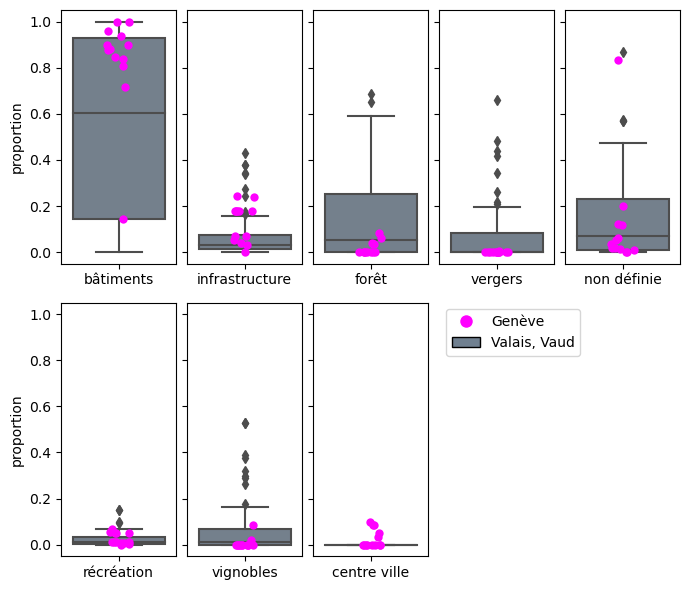

In [9]:
fig, axs = plt.subplots(2, 5, figsize=(7,6), sharey=True)

valais_locs = valais_all.slug.unique()
region_locs = not_valais.slug.unique()

index_order = [
    'Siedl',
    'infrastructure', 
    'Wald',
    'Obstanlage',
    'Undefined',
    'recreation',
    'Reben',
    'Stadtzentr',
  
]

ax_s = {
    'Siedl':[0,0],
    'infrastructure':[0,1], 
    'Wald':[0,2],
    'Obstanlage':[0,3],
    'undefined':[0,4],
    'recreation':[1,0],
    'Reben':[1,1],
    'Stadtzentr':[1,2],
}

l_used = land_use[land_use.use.isin(land_use_of_interest)]
v_land_use = land_use[land_use.slug.isin(valais_locs)].copy()
r_land_use = land_use[land_use.slug.isin(region_locs)].copy()

no_streets = [x for x in land_use_of_interest if x != "Strasse"]

for i, name in enumerate(ax_s.keys()):
    
    row = ax_s[name][0]
    column = ax_s[name][1]
    ax = axs[row, column]
    sns.stripplot(data = v_land_use[v_land_use.use == name], y = "scaled", color="magenta", zorder=20, size=6, ax=ax)
    sns.boxplot(data= r_land_use[r_land_use.use == name], y="scaled",  ax=ax, color='slategray')
    ax.set_xticks([0], [land_use_names[name]])
    ax.set_ylabel("proportion")

axs[1, 4].axis('off')
a_space = axs[1, 3]
a_space.axis('off')
h = [ Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='magenta', markersize=10), Patch(facecolor='slategray', edgecolor='black', label='Color Patch')]
l = [canton, cantons_avoisinante ]
a_space.legend(h,l, bbox_to_anchor=(0,1), loc="upper left")

plt.tight_layout()
plt.subplots_adjust(wspace=.1)
plt.show()

## Résultats des inventaires: pcs/m

La densité est calculée en additionnant tous les objets trouvés pour chaque jour et lieu d'échantillonnage. La somme pour chaque échantillon est ensuite divisée par la longueur du rivage, de la rive ou du tronçon de sentier. Pour un exemple, voir le rapport fédéral sur le calcul des lignes de base. [Baselines](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/baselines.html).

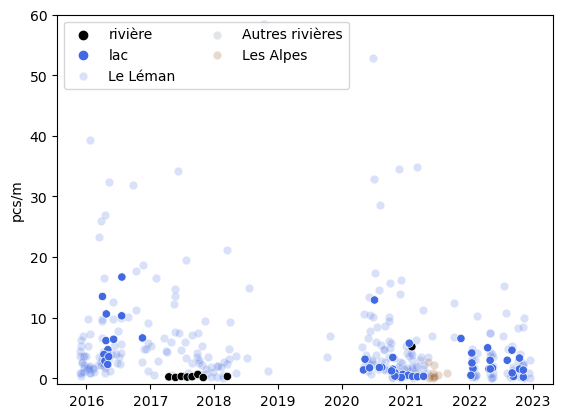

In [10]:
# # make the survey total from the list of available codes
# # survey_totals from valais
vs_jt = valais_all.groupby(["loc_date", "date", "zone"], as_index=False)["pcs/m"].sum()

# all other locations
# lake
lake_jt=not_valais[not_valais.zone == "lac"].groupby(["loc_date", "date"], as_index=False)["pcs/m"].sum()

# rivers
rhn_jt = not_valais[not_valais.zone == "rivière"].groupby(["loc_date", "date"], as_index=False)["pcs/m"].sum()

#alpes
alp_jt = not_valais[not_valais.zone == "montagne"].groupby(["loc_date", "date"], as_index=False)["pcs/m"].sum()

french_caption = "La densité totale par échantillon pour les 74 objets d'intérêt. \
Le premier prélèvement en Valais date de 2016. Les prélèvements en rivière \
et en montagne ont été réalisés lors du rapport fédéral."

fig, ax = plt.subplots()
sns.scatterplot(data=vs_jt, x="date", y="pcs/m", hue="zone", zorder=20, palette={'lac':'royalblue', 'montagne':'saddlebrown', 'rivière': 'black'}, ax=ax)
sns.scatterplot(data=lake_jt,  x="date", y="pcs/m", zorder=0, color='royalblue', alpha=0.2, ax=ax, label='Le Léman')
sns.scatterplot(data=rhn_jt, x="date", y="pcs/m", zorder=1, color='slategray', alpha=0.2, ax=ax, label='Autres rivières')
sns.scatterplot(data=alp_jt, x="date", y="pcs/m", zorder=1, color='saddlebrown', alpha=0.2, ax=ax, label='Les Alpes')
ax.set_ylim(-1, 60)
ax.legend(bbox_to_anchor=(0, 1), loc="upper left", ncol=2)
ax.set_xlabel("")
plt.show()

### Répartition de la densité des déchets

__Répartition de la densité des déchets à l'intérieur du canton: pcs/m__

In [11]:
summaries = {
    canton:vs_jt["pcs/m"].describe(),
    "Le Léman": lake_jt["pcs/m"].describe(),
    "Autres Rivières":rhn_jt["pcs/m"].describe().fillna(0),
    "Alpes": alp_jt["pcs/m"].describe().fillna(0)
    
}

zone_summaries = {
    "Lac":vs_jt[vs_jt.zone == "lac"]["pcs/m"].describe(),
    "Montagne":vs_jt[vs_jt.zone == "montagne"]["pcs/m"].describe().fillna(0),
    "Rhône":vs_jt[vs_jt.zone == "rivière"]["pcs/m"].describe().fillna(0),
    canton:vs_jt["pcs/m"].describe()
}

valais_pcsm_total = pd.DataFrame(zone_summaries)
valais_pcsm_total = valais_pcsm_total.T
valais_pcsm_total["count"] = valais_pcsm_total["count"].astype("int")
valais_pcsm_total.rename(columns=display_names, inplace=True)
valais_pcsm_total.drop("echantillons", inplace=True, axis=1)
valais_pcsm_total = valais_pcsm_total.T

english_caption_2 = f"La répartition de la densité de déchets en {canton} selon le domaine d'étude."

dis_total = valais_pcsm_total.style.set_table_styles(table_large_font).format(precision=2).set_caption(english_caption_2)
dis_total.background_gradient(axis=None, vmin=valais_pcsm_total.min().min(), vmax=valais_pcsm_total.max().max(), cmap="YlOrBr")

,Lac,Montagne,Rhône,Genève
moyenne,3.46,0.00,0.81,3.06
écart-type,3.72,0.00,1.65,3.60
min,0.13,0.00,0.11,0.11
25%,0.98,0.00,0.19,0.44
50%,2.04,0.00,0.25,1.69
75%,4.51,0.00,0.30,4.04
max,16.70,0.00,5.20,16.70


__Répartition de la densité des déchets à l'extérieur du canton: pcs/m.__

In [12]:
valais_compare = pd.DataFrame(summaries)
valais_compare = valais_compare.T
valais_compare["count"] = valais_compare["count"].astype("int")
valais_compare.rename(columns=display_names, inplace=True)
valais_compare.drop("echantillons", inplace=True, axis=1)
valais_compare = valais_compare.T

english_caption_3 = f"La répartition de la densité de déchets en {canton} comparé à d'autres localités ayant des domaines d'études similaires"
valais_compare.style.set_table_styles(table_large_font).format(precision=2).set_caption(english_caption_3)
dis_total = valais_compare.style.set_table_styles(table_large_font).format(precision=2).set_caption(english_caption_3)
dis_total.background_gradient(axis=None, vmin=valais_compare.min().min(), vmax=valais_compare.max().max(), cmap="YlOrBr")

,Genève,Le Léman,Autres Rivières,Alpes
moyenne,3.06,5.92,0.34,0.83
écart-type,3.60,8.05,0.28,0.90
min,0.11,0.02,0.00,0.07
25%,0.44,1.54,0.08,0.24
50%,1.69,3.36,0.38,0.50
75%,4.04,6.93,0.49,0.88
max,16.70,58.41,0.80,2.70


__Répartition des objets selon matériel.__

In [13]:
dfCodes = pd.read_csv("resources/codes.csv")
dfCodes.set_index("code", drop=True, inplace=True)
dfCodes.loc["Gcaps", ["material", "description", "parent_code", "groupname"]] = "Plastic", "Plastic bottle tops", "Parent code", 'food and drink'

code_d = dfCodes["description"]
code_m = dfCodes["material"]
code_g = dfCodes["groupname"]

caption_material_fr = "Total des objets par type de matériau. Tous les échantillons."

valais_all["material"] = valais_all.code.apply(lambda x: code_m.loc[x])
material_totals = valais_all.groupby("material", as_index=False).quantity.sum()
material_totals["quantity"] = material_totals.quantity.astype(int)
material_totals["material"] = material_totals.material.apply(lambda x: material_names[x])
material_totals["q_weight"] = (material_totals.quantity/material_totals.quantity.sum()).round(3)
material_totals = material_totals.set_index("material", drop=True)
material_totals.sort_values(by="quantity", ascending=False, inplace=True)
material_totals.index.name = None
material_totals.rename(columns=display_names).style.set_table_styles(table_large_font).format('{:,}').set_caption(caption_material_fr)

,quantité,% de totale
Plastique,"8,913",1.0


In [14]:
# valais_all["fail"] = valais_all['pcs/m'] > 0
# fail_rates = valais_all.groupby("code", as_index=False).fail.sum()
# n_samps = valais_all.loc_date.nunique()
# fail_rates["rate"]= fail_rates.fail/n_samps
# fail_rates = fail_rates.sort_values(by="rate", ascending=False)
# failed = fail_rates[fail_rates.rate >= .5].code.unique()

# abundant = valais_all.groupby("code", as_index=False).quantity.sum()
# abundant_c = abundant.sort_values(by="quantity", ascending=False)[:10].code.unique()

# most_common_codes = list(set([*abundant, *failed]))

# mc_data = valais_all[valais_all.code.isin(codes_of_interest)].groupby("code", as_index=False).agg({"quantity":"sum", "pcs/m":"median", "fail":"sum"})
# mc_data["fail_rate"] = (mc_data.fail/n_samps).round(2)
# mc_data["q_weight"] = (mc_data.quantity/abundant.quantity.sum()).round(2)
# mc_data["object"] = mc_data.code.apply(lambda x: french_names[x])
# mc_data = mc_data[["object", "quantity", "pcs/m", "q_weight", "fail_rate"]]

# mc_data = mc_data.sort_values(by="quantity", ascending=False)
# mc_data["quantity"] = mc_data.quantity.astype("int")
# mc_data["pcs/m"] = mc_data["pcs/m"].round(2)
# mc_data.set_index("object", drop=True, inplace=True)
# mc_data.index.name = None
# mc_data.rename(columns=display_names).style.set_table_styles(table_large_font).format('{:,}')

### Objets d'intérêt résultats municipaux: pcs/m

In [15]:
objects_city = valais_all[valais_all.code.isin(codes_of_interest)].groupby(["city","code"], as_index=False)["pcs/m"].mean()
objects_city["object"] = objects_city.code.apply(lambda x: french_names[x])
municipal_results = objects_city.pivot(columns="city", index="object", values="pcs/m").fillna(0)
municipal_results = municipal_results.round(2)
municipal_results.index.name = None
municipal_results.columns.name = None
dist = municipal_results.style.set_table_styles(table_large_font).format('{:,}').applymap_index(rotateText, axis=1)
dist.background_gradient(axis=None, vmin= municipal_results.min().min(), vmax= municipal_results.max().max(), cmap="YlOrBr")

,Genève,Hermance,Savonière,Versoix,Veyrier
"Bâche, feuille plastique industrielle",0.24,0.0,0.0,0.1,0.0
Cartouches de fusil de chasse,0.02,0.0,0.02,0.03,0.0
Coton-tige,0.14,0.0,0.15,0.35,0.01
Couvercles de bouteilles en plastique,0.19,0.0,0.13,0.26,0.08
Emballage fast food,0.03,0.0,0.0,0.01,0.03
"Emballages de bonbons, de snacks",0.51,0.03,0.35,0.41,0.0
Mégots et filtres à cigarettes,0.83,0.29,0.48,0.34,0.14
Pellets industriels (GPI),0.2,0.0,0.0,0.08,0.0
Plastiques fragmentés,1.1,0.34,0.95,1.58,0.0
Polystyrène expansé fragmenté,0.86,0.0,0.02,0.07,0.0


### Résultats par utilité d'objet: pcs/m

L'utilité d'un objet est basée sur l'utilisation de l'objet avant qu'il ne soit jeté ou sur la description de l'objet si l'utilisation d'origine n'est pas déterminée. 

* __eaux usées :__ objets rejetés par les stations d'épuration des eaux, y compris les objets susceptibles d'être jetés dans les toilettes
* __microplastiques (< 5 mm) :__ plastiques fragmentés et résines plastiques de préproduction
* __infrastructures :__ éléments liés à la construction et à l'entretien des bâtiments, des routes et de l'approvisionnement en eau et en électricité
* __alimentation et boissons :__ tous les matériaux liés à la consommation d'aliments et de boissons
* __agriculture :__ principalement les feuilles industrielles, c'est-à-dire le paillage et les couvertures de rangs, les serres, la fumigation des sols, l'enrubannage des balles. Comprend les plastiques durs pour les clôtures agricoles, les pots de fleurs, etc.
* __tabac :__ principalement les filtres de cigarettes, y compris tout le matériel lié au tabagisme
* __Loisirs :__ objets liés aux sports et aux loisirs, tels que la pêche, la chasse, la randonnée, etc.
* __Emballages non alimentaires et boissons :__ matériaux d'emballage non identifiés comme étant liés à l'alimentation, aux boissons ou au tabac.
* __fragments de plastique :__ morceaux de plastique d'origine ou d'utilisation indéterminée
* __articles personnels :__ accessoires, hygiène et vêtements

In [16]:
valais_all["groupname"] = valais_all.code.apply(lambda x: code_g.loc[x])

cg_agg = valais_all.groupby(["loc_date", "city", "groupname"], as_index=False)["pcs/m"].sum()
cg_agg["groupname"] = cg_agg.groupname.apply(lambda x: group_names[x])
cg_agg_group = cg_agg.groupby(["city","groupname"], as_index=False)["pcs/m"].median()

cg_display = cg_agg_group.pivot(columns="city", index="groupname", values=["pcs/m"])
cg_display=cg_display.round(2)
cg_display.index.name = None
cg_display.columns = cg_display.columns.droplevel()
cg_display.fillna(0, inplace=True)
cg_display.columns.name = None

dist = cg_display.style.set_table_styles(table_large_font).format('{:,}').applymap_index(rotateText, axis=1)
dist.background_gradient(axis=None, vmin=cg_display.min().min(), vmax= cg_display.max().max(), cmap="YlOrBr")

,Genève,Hermance,Savonière,Versoix,Veyrier
agriculture,0.02,0.0,0.0,0.03,0.0
alimentation et boissons,0.34,0.03,0.45,0.45,0.11
eaux usées,0.04,0.0,0.15,0.33,0.0
fragments de plastique,0.79,0.25,0.78,1.6,0.0
infrastructures,0.1,0.0,0.02,0.02,0.0
loisirs,0.0,0.0,0.01,0.02,0.0
microplastiques (< 5 mm),0.0,0.0,0.0,0.02,0.0
tabac,0.48,0.12,0.19,0.38,0.06


## Lieux d'enquêtes

In [17]:
survey_locations = valais_all[["slug", "city", "zone"]].drop_duplicates()
survey_locations.set_index("slug", inplace=True)
survey_locations.index.name = None
survey_locations.style.set_table_styles(table_large_font)

,city,zone
baby-plage,Genève,lac
hermance,Hermance,lac
port-choiseul,Versoix,lac
savoniere,Savonière,lac
versoix-p,Versoix,lac
villa-barton,Genève,lac
arve_carouge_battistellak,Veyrier,rivière
pont-sous-terre,Genève,rivière
baby-plage-geneva,Genève,lac
baby-plage-ii-geneve,Genève,lac


## Inventaire complet

In [18]:
operators = {
    "quantity":"sum",
    "pcs/m": "median",
}

valais_all["fail"] = valais_all["quantity"] > 0
code_fails = valais_all.groupby("code").fail.sum()
code_fail_rate = code_fails/valais_all.loc_date.nunique()


inventory = valais_all.groupby("code", as_index=False).agg(operators)

In [19]:

inventory["fail_rate"] = inventory.code.apply(lambda x: code_fail_rate.loc[x])
inventory = inventory[inventory.quantity > 0]
inventory["object"] =inventory.code.apply(lambda x: french_names[x])
inventory = inventory[["code", "object", "quantity", "pcs/m", "fail_rate"]]
inventory.set_index("code", inplace=True)
inventory["quantity"] = inventory.quantity.astype("int")

inventory.sort_values(by="quantity", inplace=True, ascending=False)
inventory.rename(columns=display_names, inplace=True)
inventory.index.name = None

In [20]:
inventory.style.set_table_styles(table_large_font).format(precision=3)

,object,quantité,pcs/m,fail_rate
Gfrags,Plastiques fragmentés,2872,0.809,0.814
G27,Mégots et filtres à cigarettes,2000,0.273,0.898
G30,"Emballages de bonbons, de snacks",1036,0.170,0.831
Gfoam,Polystyrène expansé fragmenté,942,0.052,0.593
G112,Pellets industriels (GPI),681,0.000,0.322
Gcaps,Couvercles de bouteilles en plastique,486,0.086,0.814
G95,Coton-tige,484,0.037,0.593
G67,"Bâche, feuille plastique industrielle",290,0.000,0.390
G70,Cartouches de fusil de chasse,70,0.000,0.288
G10,Emballage fast food,52,0.000,0.322


In [21]:

today = dt.datetime.now().date().strftime("%d/%m/%Y")
where = "Biel, CH"

my_block = f"""
<br />
<br />
This script updated {today} in {where}

\u2764\ufe0f what you do - faites ce que vous \u2764\ufe0f
"""

md(my_block)


<br />
<br />
This script updated 10/09/2023 in Biel, CH

❤️ what you do - faites ce que vous ❤️


In [22]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/cantonal_reports.git

Git branch: main

numpy     : 1.25.2
pandas    : 2.0.3
matplotlib: 3.7.1
seaborn   : 0.12.2
json      : 2.0.9

